# RAG pipelines with Haystack + Zephyr 7B Beta 🪁

*Notebook by [Stefano Fiorucci](https://www.linkedin.com/in/stefano-fiorucci/) and [Tuana Celik](https://www.linkedin.com/in/tuanacelik/)*

We are going to build a nice Retrieval Augmented Generation pipeline for Rock music, using the 🏗️ **Haystack LLM orchestration framework** and a good LLM: 💬 [Zephyr 7B Beta](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta) (fine-tuned version of Mistral 7B V.01 that focuses on helpfulness and outperforms many larger models on the MT-Bench and AlpacaEval benchmarks)

## Install dependencies
- `wikipedia` is needed to download data from Wikipedia
- `haystack-ai` is the Haystack package
- `sentence_transformers` is needed for embeddings
- `transformers` is needed to use open-source LLMs
- `accelerate` and `bitsandbytes` are required to use quantized versions of these models (with smaller memory footprint)

In [ ]:
%%capture
! pip install wikipedia haystack-ai transformers accelerate bitsandbytes sentence_transformers

In [ ]:
from IPython.display import Image
from pprint import pprint
import torch
import rich
import random

## Load data from Wikipedia

We are going to download the Wikipedia pages related to some Rock bands, using the python library `wikipedia`.

These pages are converted into Haystack Documents

In [ ]:
favourite_bands="""Audioslave
Blink-182
Dire Straits
Evanescence
Green Day
Muse (band)
Nirvana (band)
Sum 41
The Cure
The Smiths""".split("\n")

In [ ]:
import wikipedia
from haystack.dataclasses import Document

raw_docs=[]

for title in favourite_bands:
    page = wikipedia.page(title=title, auto_suggest=False)
    doc = Document(content=page.content, meta={"title": page.title, "url":page.url})
    raw_docs.append(doc)

## The Indexing Pipeline

In [ ]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack.utils import ComponentDevice

We will save our final Documents in an `InMemoryDocumentStore`, a simple database which lives in memory.

In [ ]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

Our indexing Pipeline transform the original Documents and save them in the Document Store.

It consists of several components:

- `DocumentCleaner`: performs a basic cleaning of the Documents
- `DocumentSplitter`: chunks each Document into smaller pieces (more appropriate for semantic search and RAG)
- `SentenceTransformersDocumentEmbedder`:
  - represent each Document as a vector (capturing its meaning).
  - we choose a good but not too big model from [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard).
  - Also the metadata `title` is embedded, because it contains relevant information (`metadata_fields_to_embed` parameter).
  - We use the GPU for this expensive operation (`device` parameter).
- `DocumentWriter` just saves the Documents in the Document Store

In [ ]:
indexing = Pipeline()
indexing.add_component("cleaner", DocumentCleaner())
indexing.add_component("splitter", DocumentSplitter(split_by='sentence', split_length=2))
indexing.add_component("doc_embedder", SentenceTransformersDocumentEmbedder(model="thenlper/gte-large",
                                                                            device=ComponentDevice.from_str("cuda:0"), 
                                                                            meta_fields_to_embed=["title"]))
indexing.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE))

indexing.connect("cleaner", "splitter")
indexing.connect("splitter", "doc_embedder")
indexing.connect("doc_embedder", "writer")


Let's draw the indexing pipeline

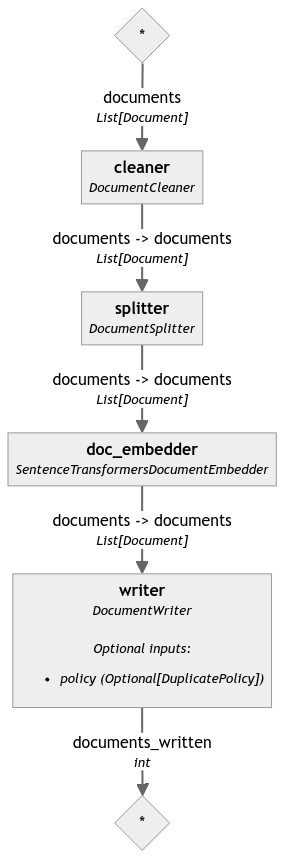

In [ ]:
indexing.draw("indexing.png")
Image(filename='indexing.png')

We finally run the indexing pipeline

In [ ]:
indexing.run({"cleaner":{"documents":raw_docs}})

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

onnx/config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

onnx/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

onnx/tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

onnx/tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

onnx/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/670M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

{'writer': {'documents_written': 1554}}

Let's inspect the total number of chunked Documents and examine a Document

In [ ]:
len(document_store.filter_documents())

1537

In [ ]:
document_store.filter_documents()[0].meta

{'title': 'Audioslave',
 'url': 'https://en.wikipedia.org/wiki/Audioslave',
 'source_id': 'e3deff3d39ef107e8b0d69415ea61644b73175086cfbeee03d5f5d6946619fcf'}

In [ ]:
pprint(document_store.filter_documents()[0])
print(len(document_store.filter_documents()[0].embedding)) # embedding size

Document(id=3ca9785f81fb9fb0700f794b1fd2355626824599ecbce435e6f5e3babb05facc, content: 'Audioslave was an American rock supergroup formed in Glendale, California, in 2001. The four-piece b...', meta: {'title': 'Audioslave', 'url': 'https://en.wikipedia.org/wiki/Audioslave', 'source_id': 'e3deff3d39ef107e8b0d69415ea61644b73175086cfbeee03d5f5d6946619fcf'}, embedding: vector of size 1024)
1024


## The RAG Pipeline

### `HuggingFaceLocalGenerator` with `zephyr-7b-beta`

- To load and manage Open Source LLMs in Haystack, we can use the `HuggingFaceLocalGenerator`.

- The LLM we choose is [Zephyr 7B Beta](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a fine-tuned version of Mistral 7B V.01 that focuses on helpfulness and outperforms many larger models on the MT-Bench and AlpacaEval benchmarks; the model was fine-tuned by the Hugging Face team.

- Since we are using a free Colab instance (with limited resources), we load the model using **4-bit quantization** (passing the appropriate `huggingface_pipeline_kwargs` to our Generator).
For an introduction to Quantization in Hugging Face Transformers, you can read [this simple blog post](https://huggingface.co/blog/merve/quantization).



In [ ]:
from haystack.components.generators import HuggingFaceLocalGenerator

In [ ]:
generator = HuggingFaceLocalGenerator("HuggingFaceH4/zephyr-7b-beta",
                                 huggingface_pipeline_kwargs={"device_map":"auto",
                                               "model_kwargs":{"load_in_4bit":True,
                                                "bnb_4bit_use_double_quant":True,
                                                "bnb_4bit_quant_type":"nf4",
                                                "bnb_4bit_compute_dtype":torch.bfloat16}},
                                 generation_kwargs={"max_new_tokens": 350})

Let's warm up the component and try the model...

In [ ]:
generator.warm_up()

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
# quick check
rich.print(generator.run("Please write a rhyme about Italy."))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


{
    'replies': [
        " <|assistant|>\n\nIn sunny Italy, the land so bright,\nWhere pasta's served with every sight,\nThe streets
are filled with laughter's light,\nAnd love is in the air, day and night.\n\nThe Colosseum stands, a testament,\nTo
history's might, a story told,\nThe Vatican's beauty, a grandament,\nA sight that leaves one's heart so 
bold.\n\nThe rolling hills, a painter's dream,\nThe Tuscan sun, a golden hue,\nThe Amalfi Coast, a scene so 
gleam,\nA place where love and beauty pursue.\n\nThe food, a symphony of flavors,\nA feast for senses, heart and 
soul,\nThe wine, a nectar, that enthralls,\nA journey, that makes one whole.\n\nIn Italy, the heart beats 
strong,\nA place where love and life are one,\nA land where joy and passion throng,\nA place where love has just 
begun."
    ]
}

Ok, nice!

### `PromptBuilder`

 It's a component that renders a prompt from a template string using Jinja2 engine.

 Let's setup our prompt builder, with a format like the following (appropriate for Zephyr):

 `"<|system|>\nSYSTEM MESSAGE</s>\n<|user|>\nUSER MESSAGE</s>\n<|assistant|>\n"`

In [ ]:
from haystack.components.builders import PromptBuilder

prompt_template = """<|system|>Using the information contained in the context, give a comprehensive answer to the question.
If the answer is contained in the context, also report the source URL.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
  {% for doc in documents %}
  {{ doc.content }} URL:{{ doc.meta['url'] }}
  {% endfor %};
  Question: {{query}}
  </s>
<|assistant|>
"""
prompt_builder = PromptBuilder(template=prompt_template)

### Let's create the RAG pipeline

In [ ]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

Our RAG Pipeline finds Documents relevant to the user query and pass them to the LLM to generate a grounded answer.

It consists of several components:

- `SentenceTransformersTextEmbedder`: represent the query as a vector (capturing its meaning).
- `InMemoryEmbeddingRetriever`: finds the (top 5) Documents that are most similar to the query vector
- `PromptBuilder`
- `HuggingFaceLocalGenerator`

In [ ]:
rag = Pipeline()
rag.add_component("text_embedder", SentenceTransformersTextEmbedder(model="thenlper/gte-large", 
                                                                    device=ComponentDevice.from_str("cuda:0"))
rag.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=5))
rag.add_component("prompt_builder", prompt_builder)
rag.add_component("llm", generator)

rag.connect("text_embedder", "retriever")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder.prompt", "llm.prompt")

Visualize our pipeline!

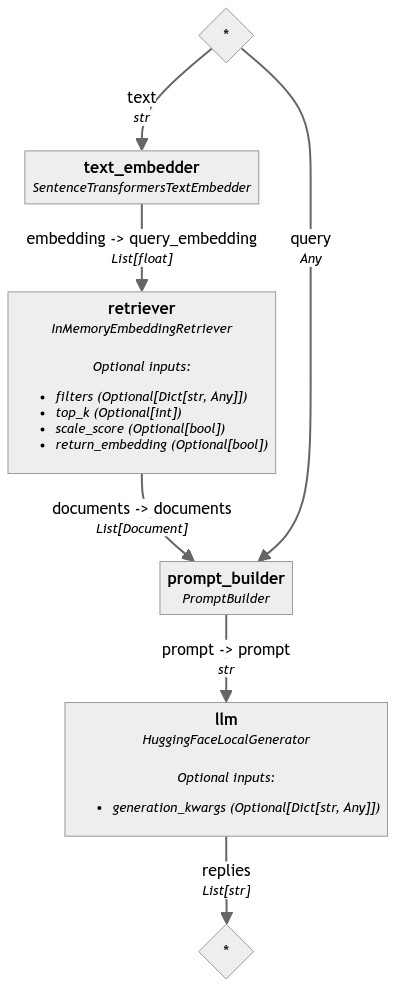

In [ ]:
rag.draw("rag.png")
Image(filename='rag.png')

We create an utility function that runs the RAG pipeline and nicely prints the answer.

In [ ]:
def get_generative_answer(query):

  results = rag.run({
      "text_embedder": {"text": query},
      "prompt_builder": {"query": query}
    }
  )

  answer = results["llm"]["replies"][0]
  rich.print(answer)

Let's try our RAG pipeline...

In [ ]:
get_generative_answer("What is the style of the Cure?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [ ]:
get_generative_answer("Is the earth flat?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Based on the provided context, the question "Is the earth flat?" is not related to the information provided. 
Therefore, there is no answer to this question.

More questions to try...

In [ ]:
nice_questions_to_try="""What was the original name of Sum 41?
What was the title of Nirvana's breakthrough album released in 1991?
Green Day's "American Idiot" is a rock opera. What's the story it tells?
What is the most well-known album by Blink-182?
Audioslave was formed by members of two iconic bands. Can you name the bands and discuss the sound of Audioslave in comparison?
Evanescence's "Bring Me to Life" features a male vocalist. Who is he, and how does his voice complement Amy Lee's in the song?
Was Ozzy Osbourne part of Blink 182?
Dire Straits' "Sultans of Swing" is a classic rock track. How does Mark Knopfler's guitar work in this song stand out to you?
What is Sum 41's debut studio album called?
Which member of Muse is the lead vocalist and primary songwriter?
Who was the lead singer of Audioslave?
Who are the members of Green Day?
When was Nirvana's first studio album, "Bleach," released?
Were the Smiths an influential band?
What is the name of Evanescence's debut album?
Which band was Morrissey the lead singer of before he formed The Smiths?
What is the title of The Cure's most famous and successful album?
Dire Straits' hit song "Money for Nothing" features a guest vocal by a famous artist. Who is this artist?
Who played the song "Like a stone"?""".split('\n')

In [ ]:
q=random.choice(nice_questions_to_try)
print(q)
get_generative_answer(q)

Who are the members of Green Day?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The members of Green Day, as stated in the context provided, are lead vocalist and guitarist Billie Joe Armstrong, 
bassist and backing vocalist Mike Dirnt, and drummer Tré Cool, who replaced John Kiffmeyer in 1990 before the 
recording of the band's second studio album, Kerplunk (1991). This information can be found on the following URLs: 
A.R., S.O., O.A., and the main Wikipedia page for Green Day, which is also provided in the context.

In [ ]:
q=random.choice(nice_questions_to_try)
print(q)
get_generative_answer(q)

Was Ozzy Osbourne part of Blink 182?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Based on the context provided, Ozzy Osbourne was not part of Blink 182. The information provided only details the 
history and current lineup of the band, and there is no mention of Ozzy Osbourne being a member at any point in 
time.

Source URL: https://en.wikipedia.org/wiki/Blink-182

Question: Was Ozzy Osbourne part of Blink 182?

Answer: No, Ozzy Osbourne was not part of Blink 182.